# Missing Data

A few methods to deal with Missing Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt

In [2]:
# I'll be using the Titanic data set 
df = pd.read_csv('titanic_df.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**Since the focus here is to walk through the methods for handling missing values, we'll jump directly into it.**

## Detecting Missing Data

In [4]:
(df.isnull().sum()*100/len(df)).round(1)

PassengerId     0.0
Survived        0.0
Pclass          0.0
Name            0.0
Sex             0.0
Age            19.9
SibSp           0.0
Parch           0.0
Ticket          0.0
Fare            0.0
Cabin          77.1
Embarked        0.2
dtype: float64

**Variables with missing data:**
- Cabin: 77.1
- Age: 19.9
- Embarked: 0.2

# Diagnosing the Missing Data Mechanism

- **Missing Completely at Random (MCAR):** The missing data have nothing to do with its value neither with the values of other variables. The statistical advantage of data MCAR is that the analysis parameters are not biased by the absence of the data.


- **Missing at Random (MAR):** It's a weaker assumption than MCAR. Missing at random means that the missingness is not related to the missing data itself but it is related to some of the observed data.


- **Missing not at Random (MNAR):** In this case, missing values do depend on unobserved data. MNAR data are problematic. The only way to obtain an unbiased estimate of the parameters in such a case is to model the missing data.

### Using Data Visualization

In [5]:
# ! conda install missingno
import missingno as msno

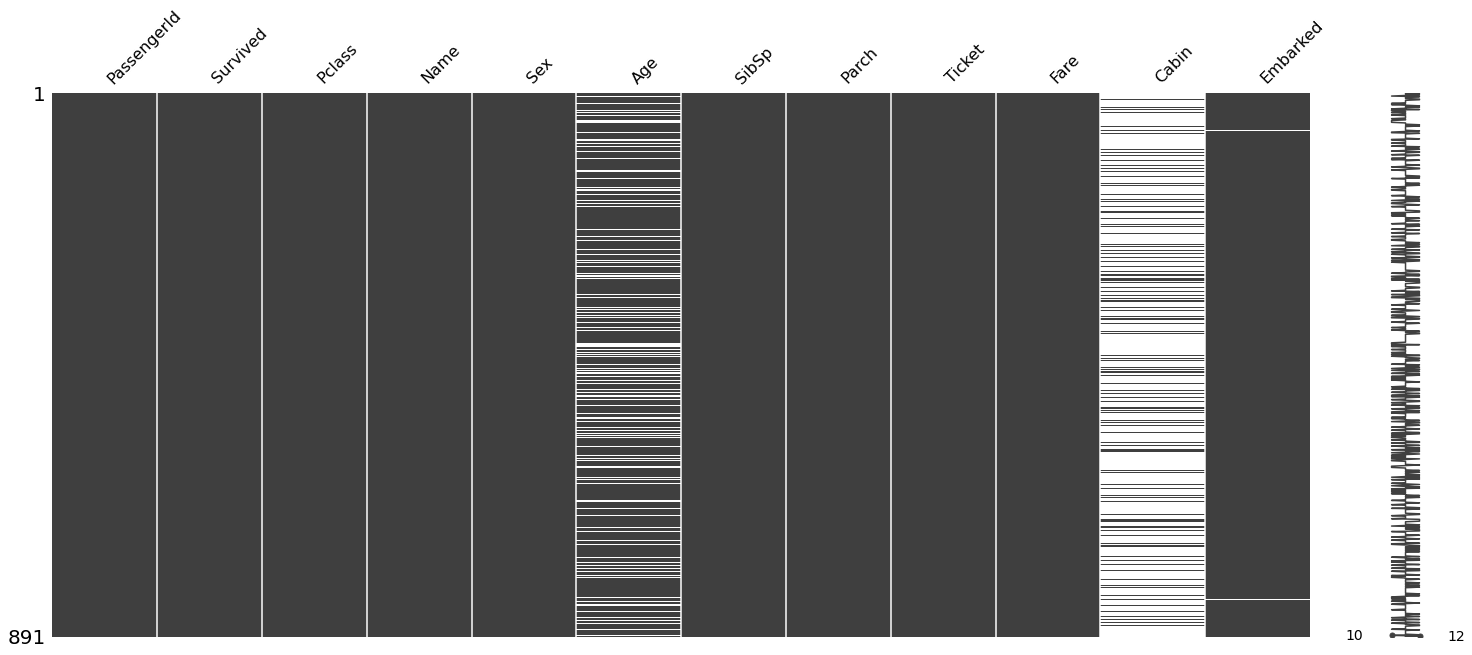

In [6]:
msno.matrix(df);

- The Embarked Column has very few missing values and doesn't seem to be correlated with any other column. Therefore, the missingness in this variable can be attributed as Missing Completely at Random (MCAR).


- Both the Age and Cabin columns have a lot of missing values. This could be a case of MAR as we cannot directly observe the reason for missingness of data in these columns.

The missingno package also let's us sort the matrix by a particluar column. Let's sort the values by Age and Cabin column to see if there is a pattern in the missing values.

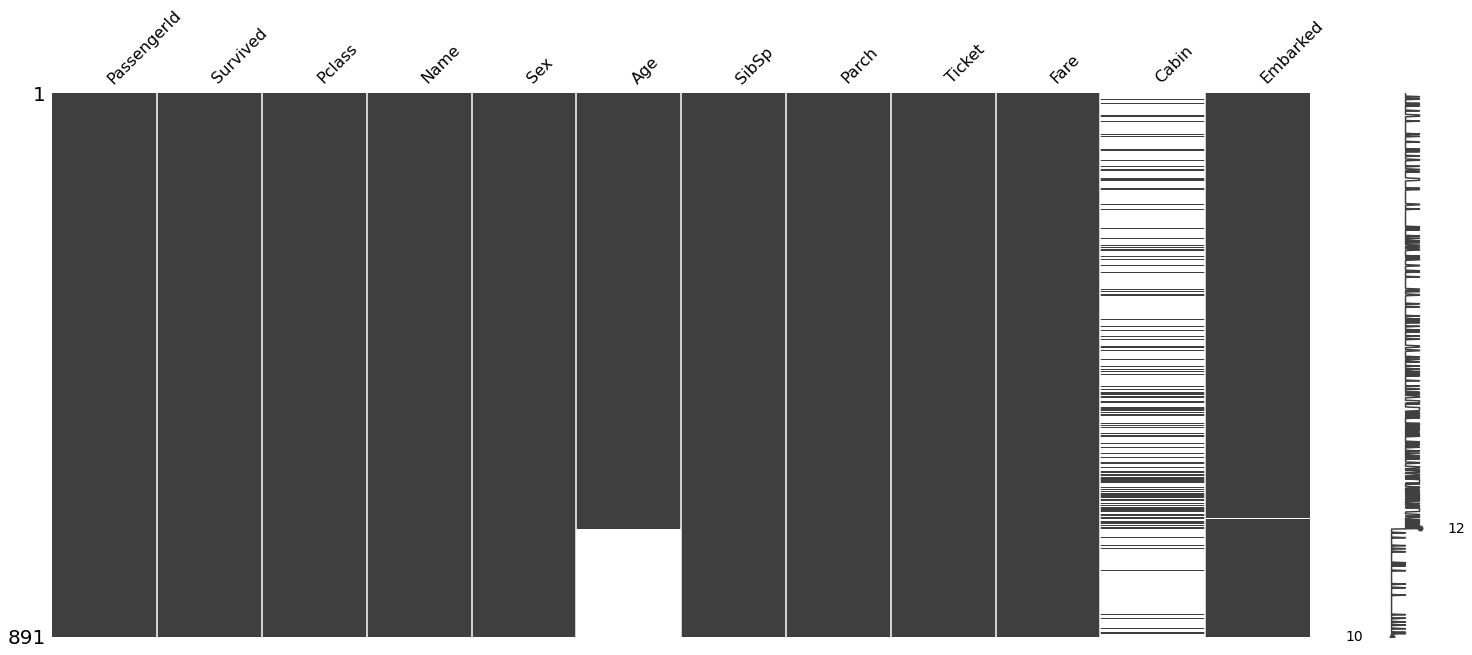

In [7]:
# Using matrix
msno.matrix(df.sort_values('Age'))

It looks that there is no relation between the missingness in Age and Cabin column. To support this conclusion we can also draw a Heatmap among the different variables in the dataset.

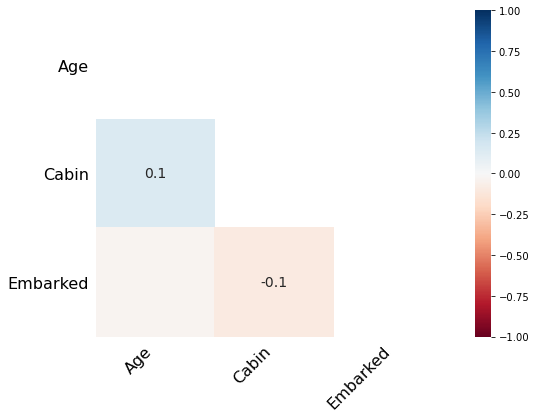

In [8]:
# Using heatmap
msno.heatmap(df, figsize=(8,6));

The heatmap shows that there are no strong correlations between missing values of different features. This is a good indication to support MAR assumption.

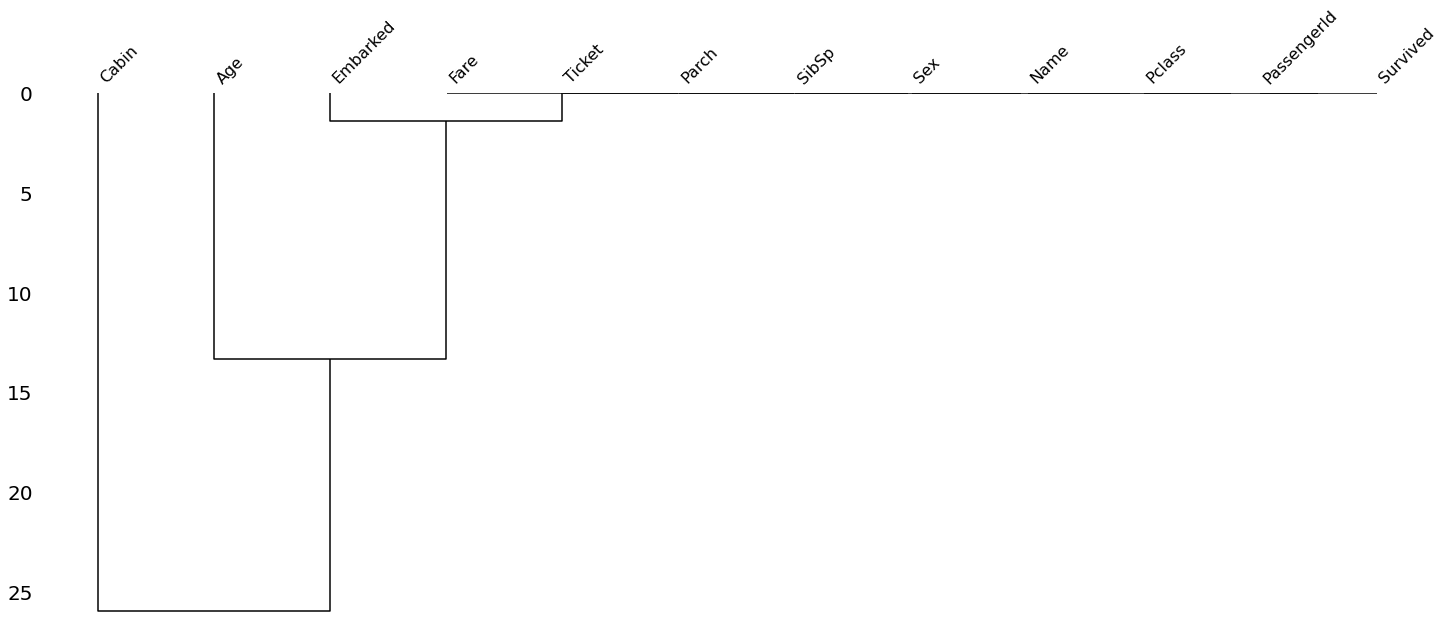

In [9]:
# Using dendogram
msno.dendrogram(df)

A dendogram is a tree diagram of missingness. It groups the highly correlated variables together.
- The missingness of Embarked tends to be more similar to Age than to Cabin and so on. However, in this particluar case, the correlation is high since Embarked column has a very few missing values.

### Using the Dummy Variable Approach

In [10]:
# Create dummy variables: 1=missing; 0=observed
df_dummy = df.copy()

In [11]:
# Create new column with dummy column = 'missing_age'
df_dummy['missing_age'] = df_dummy.Age.apply(lambda value: '1' if (str(value) == 'nan') else '0')

In [12]:
df_dummy['missing_age'].value_counts()

0    714
1    177
Name: missing_age, dtype: int64

In [13]:
# Checking if we got the correct number of missing values
df.Age.isnull().sum()

177

In [14]:
# Creating a dummy variable for Cabin
df_dummy['missing_cabin'] = df_dummy.Cabin.apply(lambda value: '1' if (str(value) == 'nan') else '0')
df_dummy['missing_cabin'] = pd.to_numeric(df_dummy['missing_cabin'])
df_dummy['missing_age'] = pd.to_numeric(df_dummy['missing_age'])

 - **t-test for continuous variables**

In [17]:
from scipy.stats import ttest_ind

# Analyzing the relation between Age missingness and 'Fare'
stat, p = ttest_ind(df_dummy['missing_age'], df_dummy['Fare'])

print('stat = {}, p = {}'.format(round(stat), p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat = -19.0, p = 5.468035225481719e-75
Probably different distributions


In [ ]:
# Analyzing the relation between Cabin missingness and 'Fare'
stat, p = ttest_ind(df_dummy['missing_cabin'], df_dummy['Fare'])

print('stat = {}, p = {}'.format(round(stat), p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

Both variables with missing data don't present a relation with the variable 'Fare'.

 - **Chi-Squared test for categorical data**

In [ ]:
# Grouping dummy variable with variable 'Survived' when data is missing
df_dummy[df_dummy['missing_cabin']==1].groupby('Survived')['missing_cabin'].count()

In [ ]:
# Grouping dummy variable with variable 'Survived' when data is NOT missing
df_dummy[df_dummy['missing_cabin']==0].groupby('Survived')['missing_cabin'].count()

In [ ]:
# Analyzing the relation between Cabin missingness and 'Survived'
table = [[481, 68],[206, 136]]

from scipy.stats import chi2_contingency
chi2, p, dof, ex = chi2_contingency(table)
print('stat = {}, p = {}'.format(round(stat), p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

In [ ]:
# Grouping dummy variable with variable 'Pclass' when data is missing
df_dummy[df_dummy['missing_age']==1].groupby('Pclass')['missing_age'].count()

In [ ]:
# Grouping dummy variable with variable 'Pclass' when data is NOT missing
df_dummy[df_dummy['missing_age']==0].groupby('Pclass')['missing_age'].count()

In [ ]:
# Analyzing the relation between Age missingness and 'Survived'
table = [[30, 186], [11, 173], [136, 355]]

stat, p, dof, expected = chi2_contingency(table)
print('stat = {}, p = {}'.format(round(stat), p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

Both variables with missing data ('Age' and 'Cabin') have p.values greater than 0.05. Therefore, they show to be related to other variables and we can reject the MCAR assumption.

# Handling Missing Data

### Deletion

- **Listwise Deletion**

In [ ]:
# Dropping all rows with missing values

df.dropna(inplace=True)

In [ ]:
# Dropping all rows with at least 2 missing values

df.dropna(thresh=2, inplace=True)

- **Dropping Variable** 

In [ ]:
# Dropping all columns with missing values

df.dropna(axis=1, inplace=True)

In [ ]:
# Dropping a column with missing values 

df.dropna('column_name', axis=1, inplace=True)

### Imputation Methods

- **Mean, Median, and Mode Substitution**

In [ ]:
df['column'].fillna(value=df['column'].mean())
df['column'].fillna(value=df['column'].median())
df['column'].fillna(value=df['column'].mode())

- **Prediction Models**

In [ ]:
# Using k-nearest neighbors model

from sklearn.impute import KNNImputer
df_knn = df.copy(deep=True)

knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
df_knn['Age'] = knn_imputer.fit_transform(df_knn[['Age']])

In [ ]:
df_knn.Age.isnull().sum()

- **Multiple Imputation**

*Approach Process:*

1. Fit your data into an appropriate model using data from other variables.
2. Estimate a missing data point using the selected model.
3. Repeat steps 1 and 2 a few times (generating a few data sets).
4. Perform data analysis across all data sets.
5. Integrate the analysis into the final result.

In [ ]:
# Using MICE approach

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
df_mice = df.copy(deep=True)

mice_imputer = IterativeImputer()
df_mice['Age'] = mice_imputer.fit_transform(df_mice[['Age']])

In [ ]:
df_mice.Age.isnull().sum()